# Illustrations for the Baseline Model

In [1]:
# import relevant packages 
from src.data.preprocess_utils import bin_data, get_acf_coefficients
from src.model.wavelet_model import * 
from sklearn.decomposition import NMF 
from scipy.signal import find_peaks
from matplotlib import pyplot as plt 
import seaborn as sns 
import numpy as np 
import pickle 
import pywt 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')



### Mother wavelet 

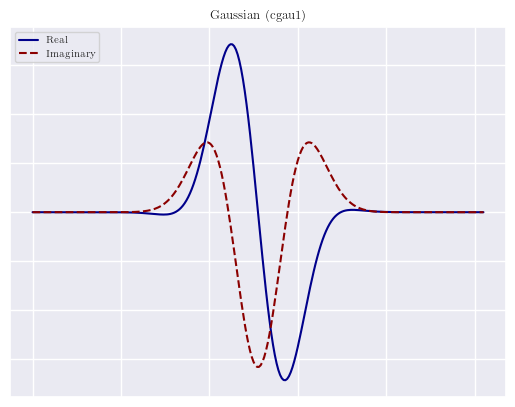

In [14]:
wavelet = pywt.ContinuousWavelet('cgau1')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Gaussian (cgau1)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "cgau1_wavelet", width = 2.5, height = 1.56)

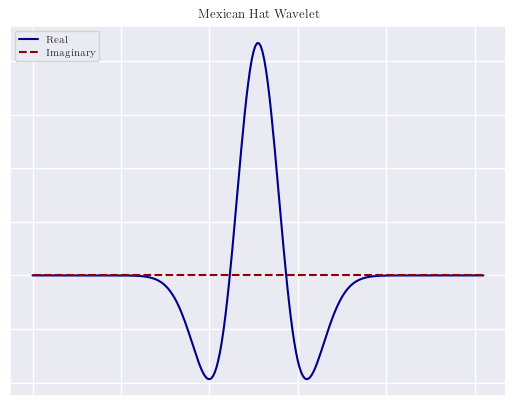

In [12]:
wavelet = pywt.ContinuousWavelet('mexh')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Mexican Hat Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mexican_hat", width = 2.5, height = 1.56)

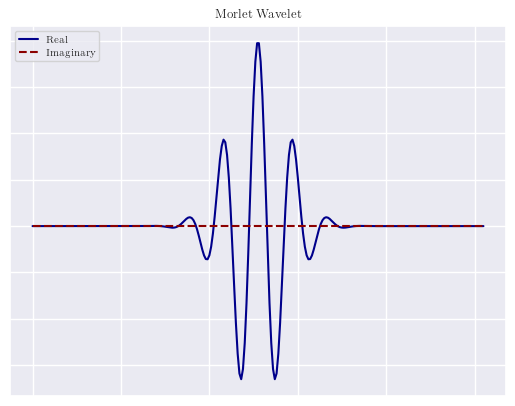

In [13]:
wavelet = pywt.ContinuousWavelet('morl')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Morlet Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mor", width = 2.5, height = 1.56)

### Wavelet Coefficients 

In [2]:
with open("simulated_data.pkl", 'rb') as f:
    file = pickle.load(f)
f.close()

channel = 2
bin_idx = 1
peaks, _ = find_peaks(file['filtered_signal'][:, channel], height = 30, distance = 2900)
bins = bin_data(file['filtered_signal'][:, channel], peaks).T 
true_bins = bin_data(file['true_signal'][:, channel], peaks).T

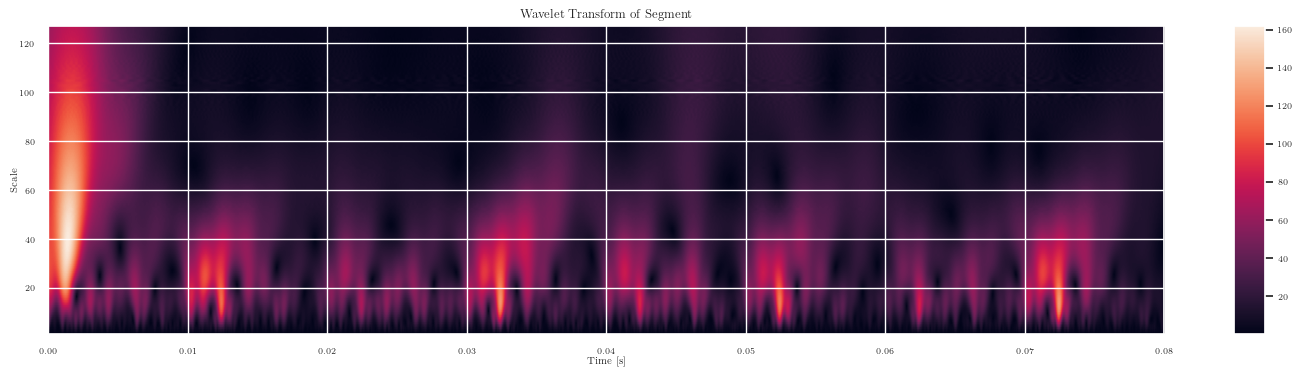

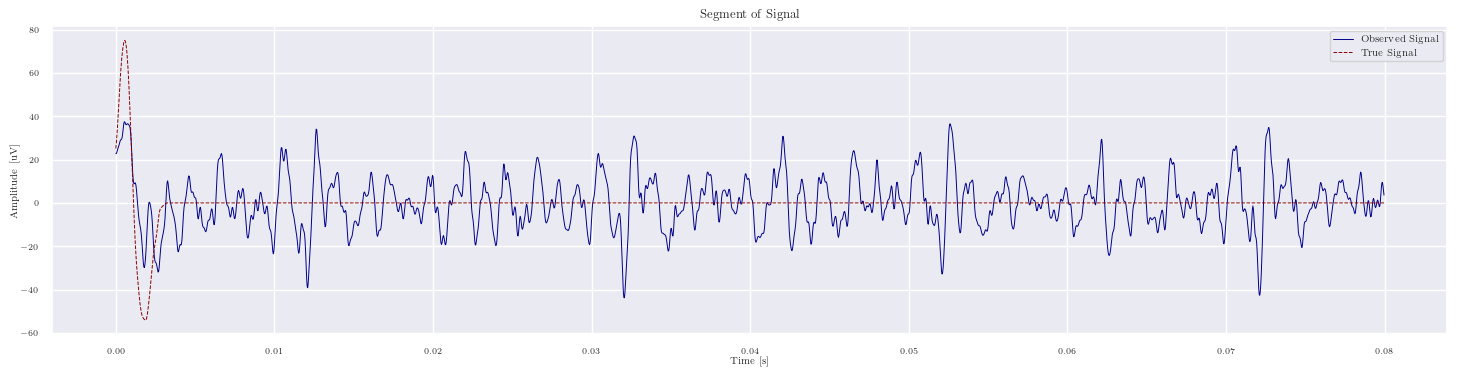

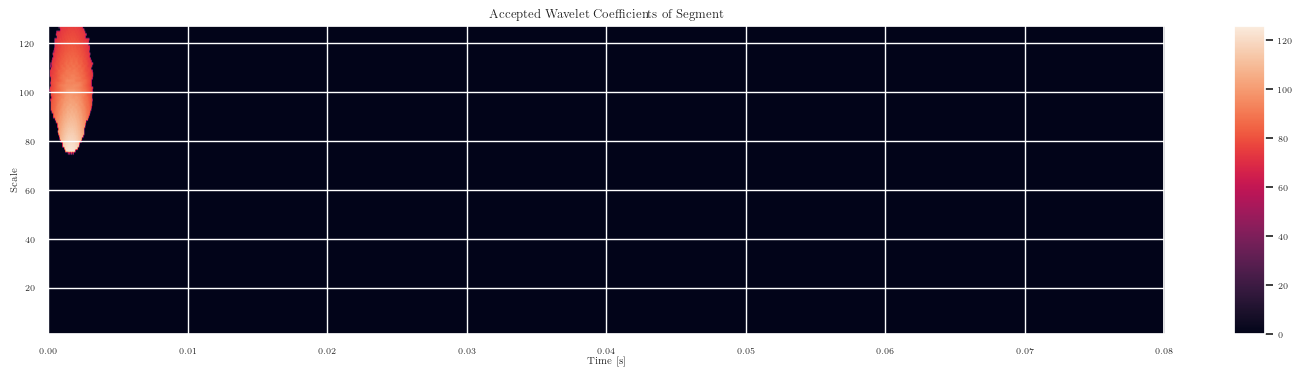

In [4]:
# apply wavelet transform
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.title("Wavelet Transform of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients", width = 6, height=1.5)

fig = plt.figure(figsize = (18, 4))
plt.plot(np.arange(2400) / 30000, bins[:, bin_idx], color = "darkblue", linewidth = 0.7)
plt.plot(np.arange(2400) / 30000, true_bins[:, bin_idx], '--', color = "darkred", linewidth = 0.7)
plt.title("Segment of Signal")
plt.ylabel("Amplitude [uV]")
plt.xlabel("Time [s]")
plt.legend(["Observed Signal", "True Signal"])
plt.show()

savefig(fig, "wavelet_time_segment", width = 6, height=1.5)

accepted_coefficients = get_accepted_coefficients(coefficients, scales)[1]

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(accepted_coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect = 10)
plt.title("Accepted Wavelet Coefficients of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients_accepted", width = 6, height=1.5)



### NMF 

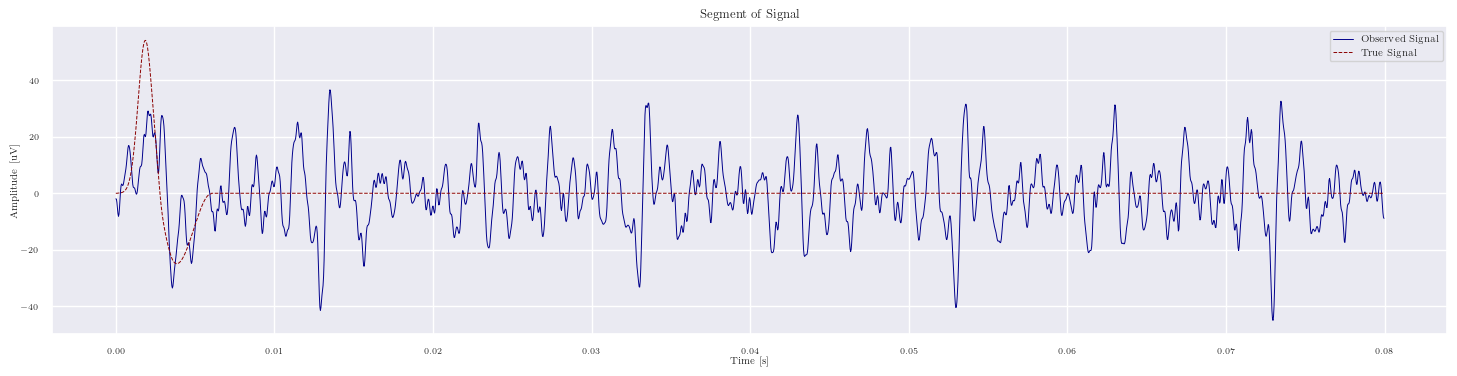

In [5]:
scales = np.arange(1, 128)
bin_idx = 2 

fig = plt.figure(figsize = (18, 4))
plt.plot(np.arange(2400) / 30000, bins[:, bin_idx], color = "darkblue", linewidth = 0.7)
plt.plot(np.arange(2400) / 30000, true_bins[:, bin_idx], '--', color = "darkred", linewidth = 0.7)
plt.title("Segment of Signal")
plt.ylabel("Amplitude [uV]")
plt.xlabel("Time [s]")
plt.legend(["Observed Signal", "True Signal"])
plt.show()


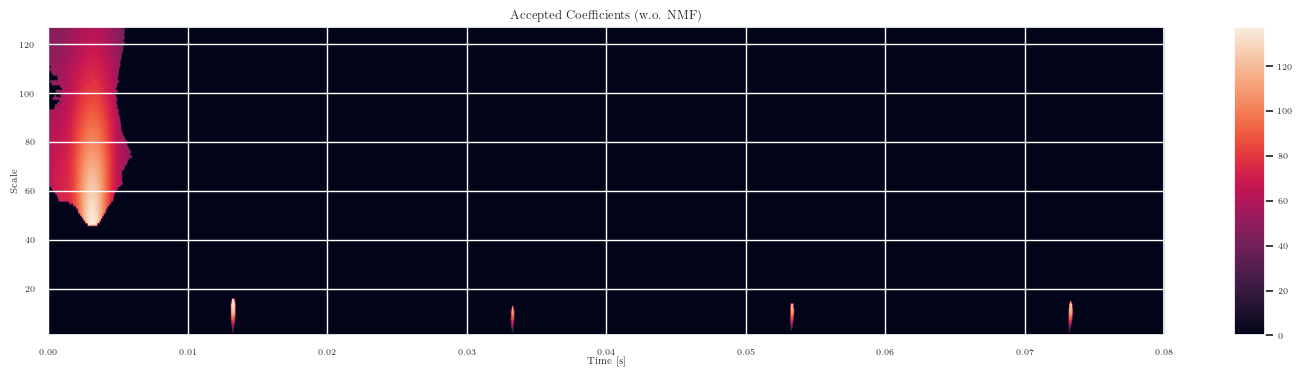

c:\Users\There\anaconda3\envs\thesis\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


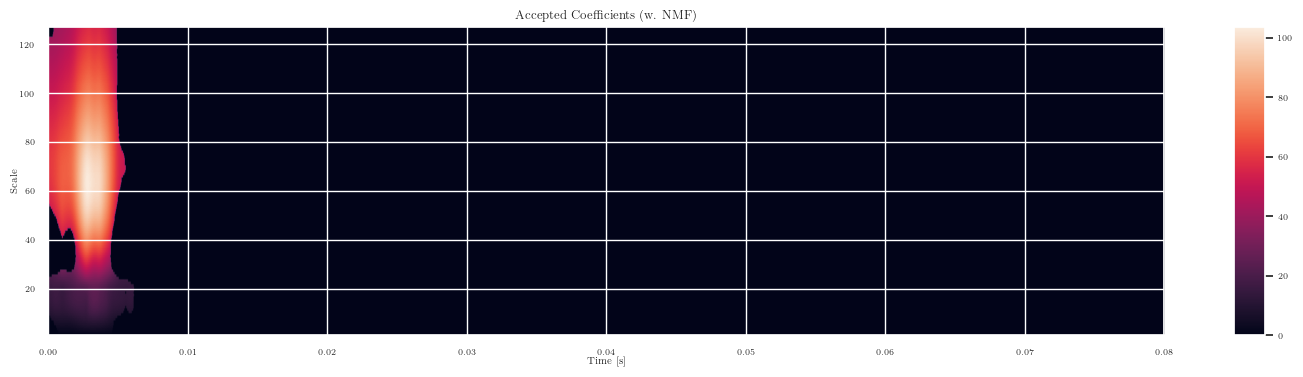

In [10]:
coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)
accepted_coefficients = get_accepted_coefficients(np.abs(coefficients), scales)[1]

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(accepted_coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower', vmin = np.abs(accepted_coefficients).min(), vmax = np.abs(accepted_coefficients).max())
plt.colorbar(aspect = 10)
plt.title("Accepted Coefficients (w.o. NMF)")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "nmf_prior_coefficients", width = 6, height=1.5)


### Apply NMF #### 
model = NMF(n_components = 127, init = "nndsvd", random_state = 42, max_iter=1000, alpha_H = 1, alpha_W = 1)
W = model.fit_transform(np.abs(coefficients).T)
H = model.components_

# remove components 
all_acfs = get_acf_coefficients(W.T)
idx = np.abs(all_acfs).argsort()[::-1][:30]
W_clean = W.copy()
W_clean[:, idx] = 0

# reconstruct the signal
reconstructed = (W_clean @ H).T 
accepted_recon = get_accepted_coefficients(reconstructed, scales)[1]

fig = plt.figure(figsize = (18, 4))
plt.imshow(accepted_recon, extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower', vmin = accepted_recon.min(), vmax = accepted_recon.max())
plt.colorbar(aspect = 10)
plt.title("Accepted Coefficients (w. NMF)")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "nmf_post_coefficients", width = 6, height=1.5)